In [1]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime, timedelta
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
import tropycal.tracks as tracks
from pydoc import help
from pyhdf.SD import *
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from io import StringIO 
import requests
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [87]:
#read in precipitation files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/abrfc_final"

#files either .cdf or .nc
#file name looks like: sgpabrfcprecipX1.c1.19971231.000000.custom.cdf
#file name looks like: sgpabrfcprecipX1.c1.20171231.000000.custom.nc

files = [
    
    os.path.join(directory_path, file)
    
    for file in os.listdir(directory_path)
    
    if file.endswith(".cdf") or file.endswith(".nc")
]

filtered_files = []

for file in files:
    
    file_name = os.path.basename(file)
    
    year_month = file_name.split('.')[2]
    
    if len(year_month) == 8:
        
        year = int(year_month[0:4])
        
        if 2013 >= year >= 2000:
            
            filtered_files.append(file)

precipdfs = []

for ds in sorted(filtered_files):
    
    ds = xr.open_dataset(ds)
    
    precipdfs.append(ds)
    
len(precipdfs)

5121

In [88]:
maxprecips = []

for df in precipdfs: 
    
    maxp = np.max(df['precip'].data)*0.01
    
    maxprecips.append(maxp)

np.max(maxprecips)

321.64

In [89]:
cleanp = []

for df in precipdfs:
    
    min_p = 0
    
    #equivalent to 250mm of rain per hour
    
    max_p = 25000

    precip = df.variables['precip'].data
          
    mask = ((precip < min_p) | (precip > max_p))

    precip_clean = np.where(mask, np.nan, precip)
    
    nan_count = np.count_nonzero(np.isnan(precip_clean))

    if nan_count == 0:
        
        cleanp.append(df)
        

print(len(cleanp))

5095


In [112]:
sgp = (36.607322, -97.487643)

max_distance = 50.0  # kilometers

precip_pairs = []

precip_index_of_pairs = []

for i in range(160):

    for j in range(336):

        lat = cleanp[0].variables["lat"].data[i, j]

        lon = cleanp[0].variables["lon"].data[i, j]

        lat_lon_pair = (lat,lon)

        distance = haversine(sgp, lat_lon_pair, unit='km')

        if distance <= max_distance:

            pair = (lat, lon)

            index = (i, j)

            precip_pairs.append(pair)

            precip_index_of_pairs.append(index)

len(precip_index_of_pairs)

472

In [96]:
# precip_pairs = []

# precip_index_of_pairs = []

# for i in range(160):

#     for j in range(336):

#         lat = cleanp[0].variables["lat"].data[i, j]

#         lon = cleanp[0].variables["lon"].data[i, j]

#         lat_lon_pair = (lat,lon)

# #         below is range for north central region 

#         if 36 <= lat <= 37 and -99.5 <= lon <= -97:

#             pair = (lat, lon)

#             index = (i, j)

#             precip_pairs.append(pair)

#             precip_index_of_pairs.append(index)

# len(precip_index_of_pairs)

1501

In [113]:
dailyp = []

for df in cleanp:
    
    #in utc 
    
    day = df['base_time'].data
    
    hrs = df.variables['precip'].shape[0]
    
    ptotal = 0
    
    count = 0 
    
    for hr in range(hrs):
    
        for index in precip_index_of_pairs:
          
            p = df.variables['precip'].data[hr,index[0],index[1]]
            count +=1 
            
            #convert to mm
            
            p = p * 0.01
                
            ptotal += p
    
    dailyavgp = ptotal/len(precip_index_of_pairs)

    tup = (day, dailyavgp, count)
    print(tup)

    dailyp.append(tup)


(numpy.datetime64('2000-01-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-03T00:00:00.000000000'), 1.9368008474576255, 11328)
(numpy.datetime64('2000-01-04T00:00:00.000000000'), 0.04415254237288137, 11328)
(numpy.datetime64('2000-01-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-08T00:00:00.000000000'), 3.0800847457627247, 11328)
(numpy.datetime64('2000-01-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-01-15T00:00:00.000000000'), 0.0, 1

(numpy.datetime64('2000-04-30T00:00:00.000000000'), 8.684618644067791, 11328)
(numpy.datetime64('2000-05-01T00:00:00.000000000'), 9.836059322033883, 11328)
(numpy.datetime64('2000-05-02T00:00:00.000000000'), 0.18029661016949144, 11328)
(numpy.datetime64('2000-05-03T00:00:00.000000000'), 0.15313559322033907, 11328)
(numpy.datetime64('2000-05-04T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2000-05-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-06T00:00:00.000000000'), 0.3645974576271178, 11328)
(numpy.datetime64('2000-05-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-09T00:00:00.000000000'), 29.740127118644008, 11328)
(numpy.datetime64('2000-05-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-05-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetim

(numpy.datetime64('2000-08-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-08-31T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-09-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-09-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-09-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-09-04T00:00:00.000000000'), 1.3767161016949143, 11328)
(numpy.datetime64('2000-09-05T00:00:00.000000000'), 0.08644067796610169, 11328)
(numpy.datetime64('2000-09-06T00:00:00.000000000'), 0.0, 11328)
(numpy.da

(numpy.datetime64('2000-12-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-25T00:00:00.000000000'), 1.219004237288133, 11328)
(numpy.datetime64('2000-12-26T00:00:00.000000000'), 14.491673728813574, 11328)
(numpy.datetime64('2000-12-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2000-12-31T00:00:00.000000000'), 8.652118644067787, 11328)
(numpy.datetime64('2001-01-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-01-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-01-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-01-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-01-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-01-06T00:00:00.000000000'), 0.0, 1132

(numpy.datetime64('2001-04-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-04-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-04-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-04-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-04-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-04-30T00:00:00.000000000'), 0.350360169491525, 11328)
(numpy.datetime64('2001-05-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-05-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-05-03T00:00:00.000000000'), 4.990762711864407, 11328)
(numpy.datetime64('2001-05-04T00:00:00.000000000'), 5.254110169491535, 11328)
(numpy.datetime64('2001-05-05T00:00:00.000000000'), 14.859385593220317, 11328)
(numpy.datetime64('2001-05-06T00:00:00.000000000'), 2.173940677966103, 11328)
(numpy.datetime64('2001-05-07T00:00:00.000000000'), 0.3480508474576271, 11328)
(numpy.datetime64('2001-05-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64(

(numpy.datetime64('2001-08-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-08-22T00:00:00.000000000'), 0.005190677966101695, 11328)
(numpy.datetime64('2001-08-23T00:00:00.000000000'), 1.8194491525423733, 11328)
(numpy.datetime64('2001-08-24T00:00:00.000000000'), 2.9726059322033977, 11328)
(numpy.datetime64('2001-08-25T00:00:00.000000000'), 0.004809322033898305, 11328)
(numpy.datetime64('2001-08-26T00:00:00.000000000'), 0.7540042372881354, 11328)
(numpy.datetime64('2001-08-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-08-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-08-29T00:00:00.000000000'), 0.17974576271186452, 11328)
(numpy.datetime64('2001-08-30T00:00:00.000000000'), 0.047605932203389836, 11328)
(numpy.datetime64('2001-08-31T00:00:00.000000000'), 18.817372881355894, 11328)
(numpy.datetime64('2001-09-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-09-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-09-03T00:00:00.00

(numpy.datetime64('2001-12-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-12-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-12-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-12-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-12-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2001-12-30T00:00:00.000000000'), 0.07504237288135579, 11328)
(numpy.datetime64('2001-12-31T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-01-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-01-02T00:00:00.000000000'), 0.1333050847457627, 11328)
(numpy.datetime64('2002-01-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-01-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-01-05T00:00:00.000000000'), 1.647012711864407, 11328)
(numpy.datetime64('2002-01-06T00:00:00.000000000'), 0.0021610169491525426, 11328)
(numpy.datetime64('2002-01-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-01-08T00:00:00.00

(numpy.datetime64('2002-04-25T00:00:00.000000000'), 0.5067161016949142, 10856)
(numpy.datetime64('2002-04-26T00:00:00.000000000'), 5.364639830508497, 11328)
(numpy.datetime64('2002-04-27T00:00:00.000000000'), 21.343008474576152, 11328)
(numpy.datetime64('2002-04-28T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2002-04-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-04-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-05-01T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2002-05-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-05-03T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2002-05-04T00:00:00.000000000'), 0.0, 8968)
(numpy.datetime64('2002-05-05T00:00:00.000000000'), 0.21427966101694917, 11328)
(numpy.datetime64('2002-05-06T00:00:00.000000000'), 2.0217372881355913, 11328)
(numpy.datetime64('2002-05-07T00:00:00.000000000'), 2.709597457627125, 11328)
(numpy.datetime64('2002-05-08T00:00:00.000000000'), 0.151906779661017, 11328)
(n

(numpy.datetime64('2002-08-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-17T00:00:00.000000000'), 6.530254237288125, 11328)
(numpy.datetime64('2002-08-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-21T00:00:00.000000000'), 10.161398305084749, 11328)
(numpy.datetime64('2002-08-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-23T00:00:00.000000000'), 0.17883474576271188, 11328)
(numpy.datetime64('2002-08-24T00:00:00.000000000'), 21.75817796610175, 11328)
(numpy.datetime64('2002-08-25T00:00:00.000000000'), 4.406800847457644, 11328)
(numpy.datetime64('2002-08-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-08-27T00:00:00.000000000'), 6.941186440677971, 11328)
(numpy.datetime64('2002-08-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64

(numpy.datetime64('2002-12-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-12T00:00:00.000000000'), 1.037224576271186, 11328)
(numpy.datetime64('2002-12-13T00:00:00.000000000'), 5.01603813559327, 11328)
(numpy.datetime64('2002-12-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-17T00:00:00.000000000'), 0.043495762711864394, 11328)
(numpy.datetime64('2002-12-18T00:00:00.000000000'), 1.082478813559324, 11328)
(numpy.datetime64('2002-12-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2002-12-23T00:00:00.000000000'), 14.61211864406777, 11328)
(numpy.datetime64('2002-12-24T00:00:00.000000000'), 2.2420550847457563, 11328)
(numpy.datetime64

(numpy.datetime64('2003-04-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-13T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2003-04-14T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2003-04-15T00:00:00.000000000'), 0.39404661016949166, 11328)
(numpy.datetime64('2003-04-16T00:00:00.000000000'), 13.894194915254245, 11328)
(numpy.datetime64('2003-04-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-18T00:00:00.000000000'), 0.12351694915254229, 11328)
(numpy.datetime64('2003-04-19T00:00:00.000000000'), 33.43610169491517, 11328)
(numpy.datetime64('2003-04-20T00:00:00.000000000'), 0.7909110169491536, 11328)
(numpy.datetime64('2003-04-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-04-2

(numpy.datetime64('2003-08-01T00:00:00.000000000'), 0.8245974576271181, 11328)
(numpy.datetime64('2003-08-02T00:00:00.000000000'), 10.850974576271165, 11328)
(numpy.datetime64('2003-08-03T00:00:00.000000000'), 2.3817796610169513, 11328)
(numpy.datetime64('2003-08-04T00:00:00.000000000'), 0.8151483050847466, 11328)
(numpy.datetime64('2003-08-05T00:00:00.000000000'), 0.7534110169491531, 11328)
(numpy.datetime64('2003-08-06T00:00:00.000000000'), 0.07101694915254235, 11328)
(numpy.datetime64('2003-08-07T00:00:00.000000000'), 0.5274152542372873, 11328)
(numpy.datetime64('2003-08-08T00:00:00.000000000'), 0.05635593220338981, 11328)
(numpy.datetime64('2003-08-09T00:00:00.000000000'), 0.2938135593220338, 11328)
(numpy.datetime64('2003-08-10T00:00:00.000000000'), 1.8581144067796584, 11328)
(numpy.datetime64('2003-08-11T00:00:00.000000000'), 1.6715677966101699, 11328)
(numpy.datetime64('2003-08-12T00:00:00.000000000'), 0.022330508474576273, 11328)
(numpy.datetime64('2003-08-13T00:00:00.000000000

(numpy.datetime64('2003-11-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-11-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-11-27T00:00:00.000000000'), 0.0031144067796610164, 11328)
(numpy.datetime64('2003-11-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-11-29T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2003-11-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-01T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2003-12-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-03T00:00:00.000000000'), 3.3359957627118724, 11328)
(numpy.datetime64('2003-12-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2003-12-09T00:00:00.000000000'), 11.305042372881346,

(numpy.datetime64('2004-03-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-03-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-03-26T00:00:00.000000000'), 3.23247881355934, 11328)
(numpy.datetime64('2004-03-27T00:00:00.000000000'), 5.60065677966101, 11328)
(numpy.datetime64('2004-03-28T00:00:00.000000000'), 33.78226694915242, 11328)
(numpy.datetime64('2004-03-29T00:00:00.000000000'), 0.07052966101694917, 11328)
(numpy.datetime64('2004-03-30T00:00:00.000000000'), 0.04093220338983052, 11328)
(numpy.datetime64('2004-03-31T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-04-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-04-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-04-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-04-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-04-05T00:00:00.000000000'), 0.14197033898305098, 11328)
(numpy.datetime64('2004-04-06T00:00:00.000000000'), 0.0, 7080)
(numpy.datetime64

(numpy.datetime64('2004-07-17T00:00:00.000000000'), 0.0005932203389830509, 10856)
(numpy.datetime64('2004-07-18T00:00:00.000000000'), 0.0, 10384)
(numpy.datetime64('2004-07-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-07-20T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2004-07-21T00:00:00.000000000'), 0.0, 10384)
(numpy.datetime64('2004-07-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-07-23T00:00:00.000000000'), 14.347394067796616, 10856)
(numpy.datetime64('2004-07-24T00:00:00.000000000'), 10.429046610169445, 10856)
(numpy.datetime64('2004-07-25T00:00:00.000000000'), 0.05442796610169494, 11328)
(numpy.datetime64('2004-07-26T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2004-07-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-07-28T00:00:00.000000000'), 18.48930084745756, 11328)
(numpy.datetime64('2004-07-29T00:00:00.000000000'), 4.896398305084769, 10384)
(numpy.datetime64('2004-07-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datet

(numpy.datetime64('2004-11-11T00:00:00.000000000'), 14.216334745762707, 11328)
(numpy.datetime64('2004-11-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2004-11-13T00:00:00.000000000'), 0.0053389830508474585, 11328)
(numpy.datetime64('2004-11-14T00:00:00.000000000'), 0.15273305084745756, 11328)
(numpy.datetime64('2004-11-15T00:00:00.000000000'), 6.376864406779661, 11328)
(numpy.datetime64('2004-11-16T00:00:00.000000000'), 1.1775635593220346, 11328)
(numpy.datetime64('2004-11-17T00:00:00.000000000'), 7.897605932203361, 11328)
(numpy.datetime64('2004-11-18T00:00:00.000000000'), 10.599343220338943, 11328)
(numpy.datetime64('2004-11-19T00:00:00.000000000'), 0.012330508474576273, 10856)
(numpy.datetime64('2004-11-20T00:00:00.000000000'), 2.0784110169491523, 11328)
(numpy.datetime64('2004-11-21T00:00:00.000000000'), 4.549745762711868, 11328)
(numpy.datetime64('2004-11-22T00:00:00.000000000'), 0.000614406779661017, 11328)
(numpy.datetime64('2004-11-23T00:00:00.000000000'), 12.7625211

(numpy.datetime64('2005-03-07T00:00:00.000000000'), 0.6338347457627117, 11328)
(numpy.datetime64('2005-03-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-09T00:00:00.000000000'), 0.027796610169491528, 11328)
(numpy.datetime64('2005-03-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-15T00:00:00.000000000'), 3.494258474576293, 11328)
(numpy.datetime64('2005-03-16T00:00:00.000000000'), 0.4168855932203376, 11328)
(numpy.datetime64('2005-03-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-03-20T00:00:00.000000000'), 0.0034110169491525424, 11328)
(numpy.datetime64('2005-0

(numpy.datetime64('2005-06-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-06-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-07-01T00:00:00.000000000'), 14.481144067796595, 11328)
(numpy.datetime64('2005-07-02T00:00:00.000000000'), 0.42582627118644084, 11328)
(numpy.datetime64('2005-07-04T00:00:00.000000000'), 44.05114406779657, 11328)
(numpy.datetime64('2005-07-05T00:00:00.000000000'), 6.11305084745763, 11328)
(numpy.datetime64('2005-07-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-07-07T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2005-07-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-07-09T00:00:00.000000000'), 0.0, 10384)
(numpy.datetime64('2005-07-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-07-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-07-12T00:00:00.000000000'), 8.507796610169496, 11328)
(numpy.datetime64('2005-07-13T00:00:00.000000000'), 2.5216101694915225, 11328)
(numpy.datetime64

(numpy.datetime64('2005-10-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-10-30T00:00:00.000000000'), 0.5901483050847457, 11328)
(numpy.datetime64('2005-10-31T00:00:00.000000000'), 25.257754237288008, 11328)
(numpy.datetime64('2005-11-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-11-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-11-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-11-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-11-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2005-11-06T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2005-11-07T00:00:00.000000000'), 0.0, 11328)
(numpy.dat

(numpy.datetime64('2006-02-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-02-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-02-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-02-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-02T00:00:00.000000000'), 0.22004237288135575, 11328)
(numpy.datetime64('2006-03-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-04T00:00:00.000000000'), 0.18065677966101704, 11328)
(numpy.datetime64('2006-03-05T00:00:00.000000000'), 0.5941101694915251, 11328)
(numpy.datetime64('2006-03-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-08T00:00:00.000000000'), 3.941016949152543, 11328)
(numpy.datetime64('2006-03-09T00:00:00.000000000'), 3.7711864406779734, 11328)
(numpy.datetime64('2006-03-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-03-1

(numpy.datetime64('2006-06-23T00:00:00.000000000'), 8.855635593220326, 11328)
(numpy.datetime64('2006-06-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-06-25T00:00:00.000000000'), 1.0861652542372886, 11328)
(numpy.datetime64('2006-06-26T00:00:00.000000000'), 0.058050847457627106, 11328)
(numpy.datetime64('2006-06-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-06-28T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2006-06-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-06-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-07-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-07-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-07-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-07-04T00:00:00.000000000'), 0.5075423728813561, 11328)
(numpy.datetime64('2006-07-05T00:00:00.000000000'), 3.730169491525425, 11328)
(numpy.datetime64('2006-07-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-07-07

(numpy.datetime64('2006-10-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-25T00:00:00.000000000'), 0.016567796610169477, 11328)
(numpy.datetime64('2006-10-26T00:00:00.000000000'), 0.014194915254237283, 11328)
(numpy.datetime64('2006-10-27T00:00:00.000000000'), 8.610148305084738, 11328)
(numpy.datetime64('2006-10-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2006-10-31T00:00:00.000000000'), 0.0,

(numpy.datetime64('2007-02-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-17T00:00:00.000000000'), 0.001271186440677966, 9912)
(numpy.datetime64('2007-02-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-24T00:00:00.000000000'), 10.547457627118638, 11328)
(numpy.datetime64('2007-02-25T00:00:00.000000000'), 0.3827330508474576, 11328)
(numpy.datetime64('2007-02-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-02-27T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2007-02-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-03-01T00:00:00.000000000'), 0.2804449152542372, 11328)
(numpy.datetime64('2007-03-02T00:00:00.0000

(numpy.datetime64('2007-06-12T00:00:00.000000000'), 0.036525423728813566, 11328)
(numpy.datetime64('2007-06-13T00:00:00.000000000'), 26.514788135593122, 11328)
(numpy.datetime64('2007-06-14T00:00:00.000000000'), 31.78885593220343, 11328)
(numpy.datetime64('2007-06-15T00:00:00.000000000'), 9.475296610169476, 11328)
(numpy.datetime64('2007-06-16T00:00:00.000000000'), 0.4436440677966102, 11328)
(numpy.datetime64('2007-06-17T00:00:00.000000000'), 4.394427966101696, 11328)
(numpy.datetime64('2007-06-18T00:00:00.000000000'), 0.07129237288135593, 11328)
(numpy.datetime64('2007-06-19T00:00:00.000000000'), 0.2540466101694915, 11328)
(numpy.datetime64('2007-06-20T00:00:00.000000000'), 18.571080508474576, 11328)
(numpy.datetime64('2007-06-21T00:00:00.000000000'), 0.2936864406779662, 11328)
(numpy.datetime64('2007-06-22T00:00:00.000000000'), 0.09078389830508478, 11328)
(numpy.datetime64('2007-06-23T00:00:00.000000000'), 0.6436440677966099, 11328)
(numpy.datetime64('2007-06-24T00:00:00.000000000'),

(numpy.datetime64('2007-10-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-07T00:00:00.000000000'), 1.8775423728813543, 11328)
(numpy.datetime64('2007-10-08T00:00:00.000000000'), 4.891822033898304, 11328)
(numpy.datetime64('2007-10-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-12T00:00:00.000000000'), 0.10682203389830511, 11328)
(numpy.datetime64('2007-10-13T00:00:00.000000000'), 0.025084745762711868, 11328)
(numpy.datetime64('2007-10-14T00:00:00.000000000'), 0.23362288135593218, 11328)
(numpy.datetime64('2007-10-15T00:00:00.000000000'), 18.003093220338982, 11328)
(numpy.datetime64('2007-10-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2007-10-17T00:00:00.000000000'), 64.70425847457632, 11328)
(numpy.datetime64('2007-10-18T00:00:00.000000000'), 0.0, 1132

(numpy.datetime64('2008-02-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-05T00:00:00.000000000'), 19.926800847457443, 11328)
(numpy.datetime64('2008-02-06T00:00:00.000000000'), 1.4069491525423945, 11328)
(numpy.datetime64('2008-02-07T00:00:00.000000000'), 0.44627118644067665, 11328)
(numpy.datetime64('2008-02-08T00:00:00.000000000'), 0.0009745762711864407, 11328)
(numpy.datetime64('2008-02-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-11T00:00:00.000000000'), 0.2049152542372881, 11328)
(numpy.datetime64('2008-02-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-02-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-0

(numpy.datetime64('2008-05-28T00:00:00.000000000'), 2.564639830508498, 11328)
(numpy.datetime64('2008-05-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-05-30T00:00:00.000000000'), 0.18942796610169493, 11328)
(numpy.datetime64('2008-05-31T00:00:00.000000000'), 0.018199152542372886, 11328)
(numpy.datetime64('2008-06-01T00:00:00.000000000'), 21.049576271186464, 11328)
(numpy.datetime64('2008-06-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-06-03T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-06-04T00:00:00.000000000'), 6.0980084745762735, 11328)
(numpy.datetime64('2008-06-05T00:00:00.000000000'), 1.763199152542372, 11328)
(numpy.datetime64('2008-06-06T00:00:00.000000000'), 50.11324152542385, 11328)
(numpy.datetime64('2008-06-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-06-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-06-09T00:00:00.000000000'), 81.54402542372894, 11328)
(numpy.datetime64('2008-06-10T00:00:00.000000000'

(numpy.datetime64('2008-09-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-09-29T00:00:00.000000000'), 0.014173728813559322, 11328)
(numpy.datetime64('2008-09-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008-10-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2008

(numpy.datetime64('2009-01-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-23T00:00:00.000000000'), 0.01826271186440678, 11328)
(numpy.datetime64('2009-01-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-26T00:00:00.000000000'), 0.4735169491525424, 11328)
(numpy.datetime64('2009-01-27T00:00:00.000000000'), 2.1448728813559463, 11328)
(numpy.datetime64('2009-01-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-29T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2009-01-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-01-31T00:00:00.000000000'), 0.0, 1

(numpy.datetime64('2009-05-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-16T00:00:00.000000000'), 5.758919491525421, 11328)
(numpy.datetime64('2009-05-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-22T00:00:00.000000000'), 0.10792372881355933, 11328)
(numpy.datetime64('2009-05-23T00:00:00.000000000'), 0.0019067796610169492, 11328)
(numpy.datetime64('2009-05-24T00:00:00.000000000'), 0.02921610169491526, 11328)
(numpy.datetime64('2009-05-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-05-26T00:00:00.000000000'), 1.6952966101694902, 11328)
(numpy.datetime64('2009-05-27T00:00:00.000000000'), 0.1436228813559322, 11328)
(numpy.datetime64('2009-05-28T00:00:00.000000000'), 0.0, 11328)
(numpy.dat

(numpy.datetime64('2009-09-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2009-09-07T00:00:00.000000000'), 2.35550847457627, 11328)
(numpy.datetime64('2009-09-08T00:00:00.000000000'), 6.397881355932202, 11328)
(numpy.datetime64('2009-09-09T00:00:00.000000000'), 3.2568432203389883, 11328)
(numpy.datetime64('2009-09-10T00:00:00.000000000'), 2.7594067796610258, 11328)
(numpy.datetime64('2009-09-11T00:00:00.000000000'), 9.707139830508446, 11328)
(numpy.datetime64('2009-09-12T00:00:00.000000000'), 6.593199152542403, 11328)
(numpy.datetime64('2009-09-13T00:00:00.000000000'), 1.0943008474576297, 11328)
(numpy.datetime64('2009-09-14T00:00:00.000000000'), 0.384449152542372, 11328)
(numpy.datetime64('2009-09-15T00:00:00.000000000'), 1.0833262711864398, 11328)
(numpy.datetime64('2009-09-16T00:00:00.000000000'), 0.07724576271186444, 11328)
(numpy.datetime64('2009-09-17T00:00:00.000000000'), 0.007627118644067798, 11328)
(numpy.datetime64('2009-09-18T00:00:00.000000000'), 0.0, 11328)
(numpy

(numpy.datetime64('2009-12-31T00:00:00.000000000'), 0.0003177966101694915, 11328)
(numpy.datetime64('2010-01-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-03T00:00:00.000000000'), 0.45970338983050774, 11328)
(numpy.datetime64('2010-01-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-07T00:00:00.000000000'), 0.020783898305084755, 11328)
(numpy.datetime64('2010-01-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-01-14T00:00:00.000000000'), 0

(numpy.datetime64('2010-04-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-04-30T00:00:00.000000000'), 10.498665254237274, 11328)
(numpy.datetime64('2010-05-01T00:00:00.000000000'), 0.6730296610169498, 11328)
(numpy.datetime64('2010-05-02T00:00:00.000000000'), 0.13074152542372877, 11328)
(numpy.datetime64('2010-05-03T00:00:00.000000000'), 0.7872669491525425, 11328)
(numpy.datetime64('2010-05-04T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2010-05-05T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-05-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-05-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-05-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-05-09T00:00:00.000000000'), 0.5457838983050844, 11328)
(numpy.datetime64('2010-05-10T00:00:00.000000000'), 8.747521186440855, 11328)
(numpy.datetime64('2010-05-11T00:00:00.000000000'), 0.08434322033898307, 11328)
(numpy.datetime64('2010-05-12T00:00:00.000000000'), 0.03741525

(numpy.datetime64('2010-08-17T00:00:00.000000000'), 42.61805084745775, 11328)
(numpy.datetime64('2010-08-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-20T00:00:00.000000000'), 0.0010381355932203389, 11328)
(numpy.datetime64('2010-08-21T00:00:00.000000000'), 4.110635593220345, 11328)
(numpy.datetime64('2010-08-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-24T00:00:00.000000000'), 14.464131355932196, 11328)
(numpy.datetime64('2010-08-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-08-30T00:00:00.000000000'), 0.0601271186440678, 11328)
(numpy.datetime64('2010-08-3

(numpy.datetime64('2010-12-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-24T00:00:00.000000000'), 3.4919279661017426, 11328)
(numpy.datetime64('2010-12-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-12-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2010-1

(numpy.datetime64('2011-04-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-14T00:00:00.000000000'), 0.029427966101694916, 11328)
(numpy.datetime64('2011-04-15T00:00:00.000000000'), 0.48436440677966086, 11328)
(numpy.datetime64('2011-04-16T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-04-20T00:00:00.000000000'), 0.0035169491525423734, 11328)
(numpy.datetime64('2011-04-21T00:00:00.000000000'), 2.193601694915254, 11328)
(numpy.datetime64('2011-04-22T00:00:00.000000000'), 0.42805084745762373, 11328)
(numpy.datetime64('2011-04-23T00:00:00.000000000'), 0.290635593220339, 11328)
(numpy.datetime64('2011-04-24T00:00:00.000000000'), 4.11495762711872, 11328)
(numpy.datetime64('2011-04-25T00:00:00.000000000'), 12.65819

(numpy.datetime64('2011-08-05T00:00:00.000000000'), 0.2548940677966101, 11328)
(numpy.datetime64('2011-08-06T00:00:00.000000000'), 1.6166949152542311, 11328)
(numpy.datetime64('2011-08-07T00:00:00.000000000'), 1.4713771186440652, 11328)
(numpy.datetime64('2011-08-08T00:00:00.000000000'), 0.3158474576271186, 11328)
(numpy.datetime64('2011-08-09T00:00:00.000000000'), 5.752224576271174, 11328)
(numpy.datetime64('2011-08-10T00:00:00.000000000'), 14.72529661016948, 11328)
(numpy.datetime64('2011-08-11T00:00:00.000000000'), 9.192288135593223, 11328)
(numpy.datetime64('2011-08-12T00:00:00.000000000'), 5.094449152542373, 11328)
(numpy.datetime64('2011-08-12T00:00:00.000000000'), 5.0321398305084735, 10384)
(numpy.datetime64('2011-08-13T00:00:00.000000000'), 24.350338983050886, 11328)
(numpy.datetime64('2011-08-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-08-15T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-08-16T00:00:00.000000000'), 2.8900635593220327, 11328)
(numpy.

(numpy.datetime64('2011-11-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-11-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-11-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-11-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-03T00:00:00.000000000'), 18.41949152542368, 11328)
(numpy.datetime64('2011-12-04T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-05T00:00:00.000000000'), 0.004661016949152543, 11328)
(numpy.datetime64('2011-12-06T00:00:00.000000000'), 0.46694915254237274, 11328)
(numpy.datetime64('2011-12-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-08T00:00:00.000000000'), 0.0, 10856)
(numpy.datetime64('2011-12-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2011-12-11T00:00:00.000000000'), 1.686

(numpy.datetime64('2012-03-28T00:00:00.000000000'), 0.22620762711864406, 11328)
(numpy.datetime64('2012-03-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-03-30T00:00:00.000000000'), 0.16817796610169491, 11328)
(numpy.datetime64('2012-03-31T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-04-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-04-02T00:00:00.000000000'), 0.0641313559322034, 11328)
(numpy.datetime64('2012-04-03T00:00:00.000000000'), 2.4227966101695064, 11328)
(numpy.datetime64('2012-04-04T00:00:00.000000000'), 0.8748728813559331, 11328)
(numpy.datetime64('2012-04-05T00:00:00.000000000'), 0.07989406779661017, 11328)
(numpy.datetime64('2012-04-06T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-04-07T00:00:00.000000000'), 4.982563559322035, 11328)
(numpy.datetime64('2012-04-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-04-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-04-10T00:00:00.000000000'), 0.0, 1132

(numpy.datetime64('2012-07-20T00:00:00.000000000'), 2.5868855932203423, 11328)
(numpy.datetime64('2012-07-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-25T00:00:00.000000000'), 0.07877118644067796, 11328)
(numpy.datetime64('2012-07-26T00:00:00.000000000'), 0.16633474576271196, 11328)
(numpy.datetime64('2012-07-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-07-31T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-08-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-08-02T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-08-03T00:00:00.000000000'), 0.720

(numpy.datetime64('2012-11-17T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-18T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-19T00:00:00.000000000'), 1.4459957627118656, 11328)
(numpy.datetime64('2012-11-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-22T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-23T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-24T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-11-30T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-12-01T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2012-1

(numpy.datetime64('2013-03-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-21T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-22T00:00:00.000000000'), 1.1436864406779654, 11328)
(numpy.datetime64('2013-03-23T00:00:00.000000000'), 2.3476059322034137, 11328)
(numpy.datetime64('2013-03-24T00:00:00.000000000'), 1.8703389830508494, 11328)
(numpy.datetime64('2013-03-25T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-26T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-27T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-28T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-29T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-03-30T00:00:00.000000000'), 2.6750423728813613, 11328)
(numpy.datetime64('2013-03-31T00:00:00.000000000'), 3.5300211864406945, 11328)
(numpy.datetime64('2013-04-01T00:00:00.000000000'), 0.13322033898305083, 11328)
(numpy.dateti

(numpy.datetime64('2013-07-11T00:00:00.000000000'), 5.61449152542373, 11328)
(numpy.datetime64('2013-07-12T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-07-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-07-14T00:00:00.000000000'), 34.13080508474579, 11328)
(numpy.datetime64('2013-07-15T00:00:00.000000000'), 4.565762711864439, 11328)
(numpy.datetime64('2013-07-16T00:00:00.000000000'), 0.2967372881355933, 11328)
(numpy.datetime64('2013-07-17T00:00:00.000000000'), 6.579449152542363, 11328)
(numpy.datetime64('2013-07-18T00:00:00.000000000'), 0.0450635593220339, 11328)
(numpy.datetime64('2013-07-19T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-07-20T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-07-21T00:00:00.000000000'), 20.265911016949122, 11328)
(numpy.datetime64('2013-07-22T00:00:00.000000000'), 0.0005508474576271186, 11328)
(numpy.datetime64('2013-07-23T00:00:00.000000000'), 2.0574152542372874, 11328)
(numpy.datetime64('2013-07-24T00:00

(numpy.datetime64('2013-11-04T00:00:00.000000000'), 0.31908898305084715, 11328)
(numpy.datetime64('2013-11-05T00:00:00.000000000'), 0.8155720338983036, 11328)
(numpy.datetime64('2013-11-06T00:00:00.000000000'), 26.577161016949166, 11328)
(numpy.datetime64('2013-11-07T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-08T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-09T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-10T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-11T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-12T00:00:00.000000000'), 0.05033898305084738, 11328)
(numpy.datetime64('2013-11-13T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-14T00:00:00.000000000'), 0.0, 11328)
(numpy.datetime64('2013-11-15T00:00:00.000000000'), 0.004300847457627119, 11328)
(numpy.datetime64('2013-11-16T00:00:00.000000000'), 0.3146610169491526, 11328)
(numpy.datetime64('2013-11-17T00:00:00.000000000'), 0.2871610169491526, 11

In [99]:
dailypdf = pd.DataFrame(dailyp, columns=['day','p','count'])

dailypdf = dailypdf.set_index("day")

dailypdf.index = dailypdf.index.strftime('%Y')

dailypdf['p'] = dailypdf['p'] * 0.0393701

In [100]:
# yearly trend

yearlyp = dailypdf.groupby(dailypdf.index)['p'].agg(['sum', 'count'])

yearlyp

,sum,count
day,,
2000,33.671397,361
2001,23.904759,350
2002,34.590104,364
2003,24.481646,365
2004,32.711128,363
2005,27.408320,364
2006,20.029937,365
2007,39.906917,364
2008,35.491414,366


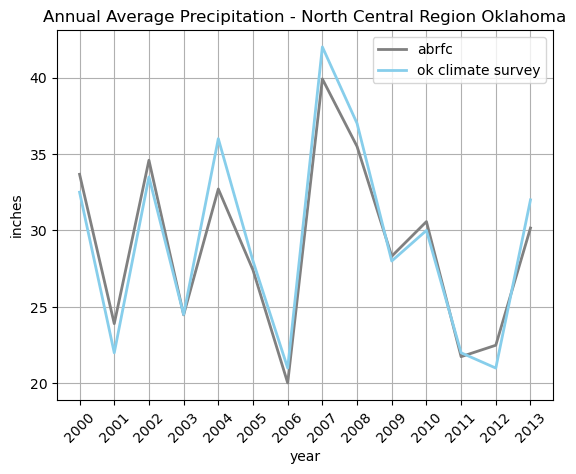

In [110]:
okclimate = np.array([32.5, 22, 33.5, 24.5, 36, 28, 21, 42, 37, 28, 30, 22, 21, 32])

# plt.scatter(yearlyp.index, yearlyp['sum'].values)
# plt.scatter(yearlyp.index, okclimate)

plt.plot(yearlyp.index, yearlyp['sum'].values, color='grey',linewidth=2,label='abrfc')
plt.plot(yearlyp.index, okclimate, color='skyblue',linewidth=2,label='ok climate survey')

plt.xticks(rotation=45) 

plt.grid()
plt.ylabel("inches")
plt.legend()
plt.xlabel("year")
plt.title("Annual Average Precipitation - North Central Region Oklahoma")
plt.show()